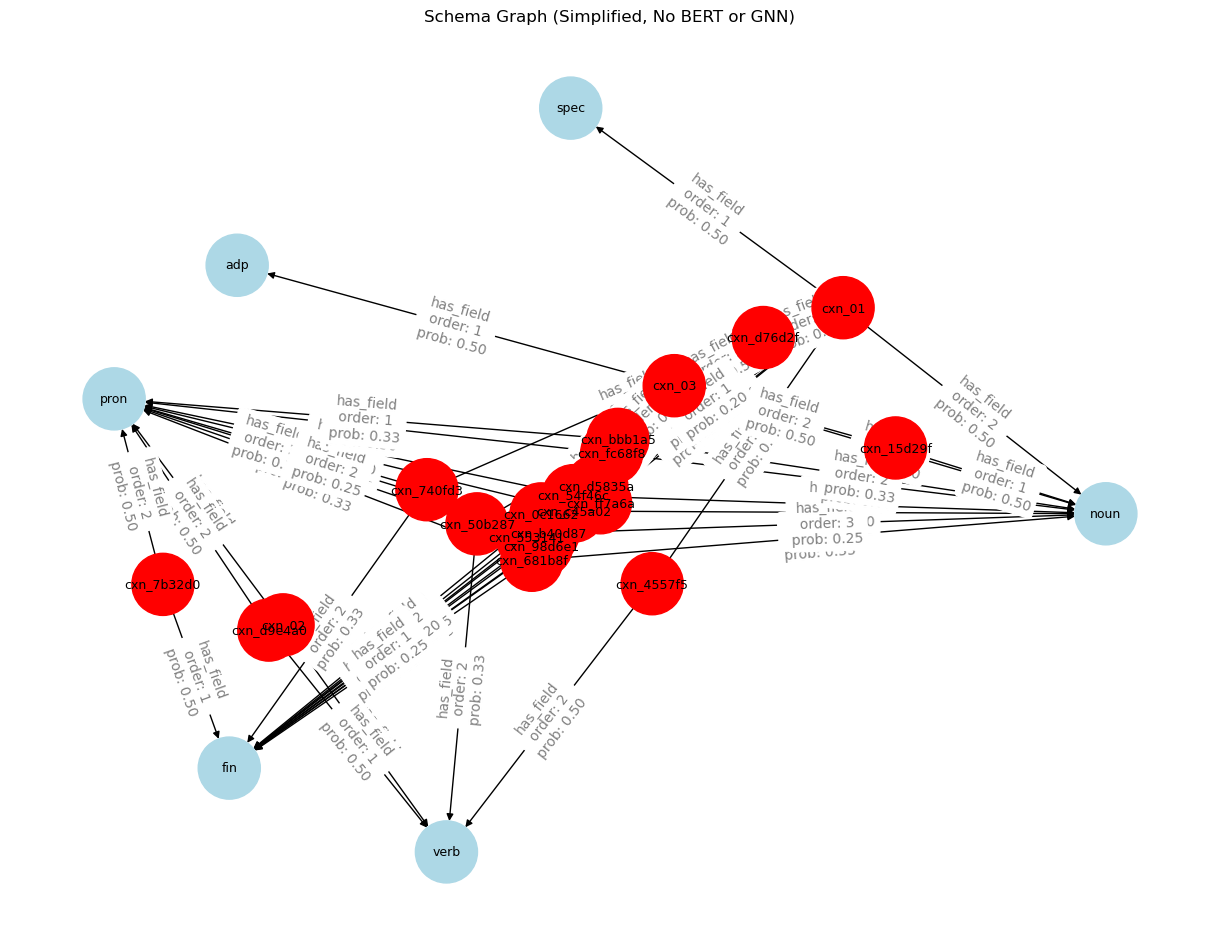

Saved graph to 'schema_graph.graphml'


In [3]:
# Simplified Schema Graph Builder (No BERT, No GNN)

import csv
import hashlib
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict, Counter

# === Load schema nodes and edges from CSV files ===
schema_nodes = []
with open("schema_nodes.csv", newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        schema_nodes.append({"id": row["id"], "type": "Schema", "logic": row["logic"]})

schema_edges = []
with open("schema_edges.csv", newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        schema_edges.append((row["src"], row["dst"], int(row["order"])))

# === Load stream of sentences (one per line, with alternates using '|') ===
stream = []
with open("schema_stream.txt", "r") as f:
    for line in f:
        tokens = line.strip().split()
        expanded = []
        for tok in tokens:
            if '|' in tok:
                expanded.append(tok.split('|'))
            else:
                expanded.append([tok])
        # Cartesian product of token options per position
        from itertools import product
        for variant in product(*expanded):
            stream.append(["BOS"] + list(variant) + ["EOS"])

# === Load blacklist of sequences ===
blacklist = []
with open("blacklist.txt", "r") as f:
    for line in f:
        tokens = tuple(line.strip().split())
        if tokens:
            blacklist.append(tokens)

# === Build known schema definitions ===
schema_defs = defaultdict(list)
for schema, child, order in schema_edges:
    schema_defs[schema].append((order, child))
schema_defs = {k: [c for _, c in sorted(v)] for k, v in schema_defs.items()}

# === Function: Replace known schema chunks ===
def replace_known_chunks(sentence, schema_defs):
    matches = []
    for i in range(len(sentence)):
        for schema, fields in schema_defs.items():
            length = len(fields)
            if i + length <= len(sentence) and tuple(sentence[i:i+length]) == tuple(fields):
                matches.append((i, i+length, schema))
    matches.sort()
    new_sentence = []
    i = 0
    while i < len(sentence):
        found = False
        for start, end, schema in matches:
            if i == start:
                new_sentence.append(schema)
                i = end
                found = True
                break
        if not found:
            new_sentence.append(sentence[i])
            i += 1
    return new_sentence

# === Process stream and update graph ===
chunked_stream = []
seq_counter = defaultdict(int)

for sent in stream:
    inner = sent[1:-1]  # remove BOS and EOS
    chunked = replace_known_chunks(inner, schema_defs)
    chunked_stream.append(["BOS"] + chunked + ["EOS"])
    for i in range(len(chunked)):
        for j in range(i + 1, len(chunked) + 1):
            subseq = tuple(chunked[i:j])
            if len(subseq) > 1:
                seq_counter[subseq] += 1

# === Add new schema nodes from frequent sequences ===
min_count = 1
new_schemas = [seq for seq, count in seq_counter.items() if count >= min_count and seq not in blacklist]

schema_index = {n["id"]: i for i, n in enumerate(schema_nodes)}
for seq in new_schemas:
    schema_id = "cxn_" + hashlib.md5("_".join(seq).encode()).hexdigest()[:6]
    if schema_id not in schema_index:
        schema_nodes.append({"id": schema_id, "type": "Schema", "logic": "AND"})
        for i, token in enumerate(seq):
            schema_edges.append((schema_id, token, i + 1))

# === Build and visualize graph ===
G = nx.DiGraph()
child_counter = Counter(dst for _, dst, _ in schema_edges)

for node in schema_nodes:
    node_id = node["id"]
    reuse = sum(1 for s, d, _ in schema_edges if s == node_id and child_counter[d] > 1)
    color = "red" if reuse >= 1 else ("orange" if node_id.startswith("cxn_") else "lightblue")
    G.add_node(node_id, color=color)

edge_counts = Counter((src, dst) for src, dst, _ in schema_edges)
total_from_src = Counter(src for src, _, _ in schema_edges)

for src, dst, order in schema_edges:
    prob = edge_counts[(src, dst)] / total_from_src[src]
    G.add_edge(src, dst, relation="has_field", order=order, weight=prob)

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 9))
node_colors = [G.nodes[n].get("color", "lightblue") for n in G.nodes()]
labels = {(u, v): f"{d['relation']}\norder: {d.get('order', '')}\nprob: {d.get('weight', 0):.2f}" for u, v, d in G.edges(data=True)}

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=9)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='gray')
plt.title("Schema Graph (Simplified, No BERT or GNN)")
plt.axis('off')
plt.show()

# Save to GraphML
nx.write_graphml(G, "schema_graph.graphml")
print("Saved graph to 'schema_graph.graphml'")
